In [1]:
print('Installing packages...')
! pip install torch transformers accelerate sentencepiece  datasets tqdm zstandard

In [2]:
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
import gc

In [3]:
model_path = "facebook/opt-1.3b"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="cuda")
dataset=load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [4]:
n_samples=50
def evaluate_perplexity(model,tokenizer):
    tokenized_data=tokenizer("/n/n".join(dataset['text']),return_tensors='pt')
    tokens=tokenized_data.input_ids
    model.eval()
    total_loss=0.0
    tokens.to(model.device)
    for i in tqdm.tqdm(range(n_samples)):
        batch=tokens[:,i*2048:(i+1)*2048].to(model.device)
        with torch.no_grad():
            logits=model(batch).logits
            shift_logits=logits[:,:-1,:].contiguous()
            shift_labels=batch[:,1:].contiguous()
            loss_fct=nn.CrossEntropyLoss()
            loss=loss_fct(shift_logits.view(-1,shift_logits.size(-1)),shift_labels.view(-1))
            total_loss+=loss.item()
            del logits
            del shift_logits
            del shift_labels
            del loss
        del batch
    return(torch.exp(torch.tensor(total_loss/(n_samples))))

def model_size(model,data_width=16,group_size=-1):
    if group_size!=-1:
        scale_width=16
        zero_point_width=4
        data_width+= (scale_width + zero_point_width)/group_size
    num_params=0
    for n,m in model.named_parameters():
        num_params+=m.numel()
    size_in_bits=num_params*data_width
    size_in_megabytes=size_in_bits/(8*1024*1024)
    return size_in_megabytes



In [5]:
### Model info 
print(f'Model size (in MB): {model_size(model,data_width=32,group_size=-1)}')
print(f'Model perplexity: {evaluate_perplexity(model,tokenizer)}')
del model

Model size (in MB): 5019.21875


100%|██████████| 50/50 [01:11<00:00,  1.43s/it]

Model perplexity: 13.209306716918945


Given a high-precision tensor $W$ (e.g., FP32), uniform quantization aims to represent each weight using a lower bit-width while minimizing the error between $W$ and its quantized version $Q(W)$.

Assume that the values of $W$ lie in the range $[\alpha, \beta]$ and that we target a bit-width of $b$ bits. The quantized representation is:

- Quantized integer: $q$
- Scale factor: $S$
- Zero Point: $z$

The quantized reconstruction is:
$$
Q(W) = S \cdot (q - z)
$$

The scale and zero-point are defined as:
$$
S = \frac{\beta - \alpha}{2^{b} - 1} \tag{1}
$$

$$
z = -\text{Round}\left( \frac{\alpha}{S} \right) \tag{2}
$$

Thus, each weight $w \in W$ is quantized as:
$$
q(w) = \text{Clamp}\left( \text{Round}\left(\frac{w}{S}\right) + z,\ 0,\ 2^{b} - 1 \right) \tag{3}
$$


In [7]:
def pseudo_quantize_tensor(tensor, num_bits=8, group_size=-1):
    original_shape=tensor.shape
    if group_size!=-1:
        if original_shape[-1]%group_size!=0:
            raise ValueError("The last dimension of the tensor must be divisible by group_size")
        tensor=tensor.view(-1,group_size)
    # alpha and beta calculation
    alpha=0
    beta=2**num_bits - 1
    max_int=beta-alpha
    min_val=tensor.min(dim=-1,keepdim=True).values
    max_val=tensor.max(dim=-1,keepdim=True).values
    scales=(max_val - min_val)/(max_int)
    zero_points=torch.round(-min_val/scales).clamp(alpha,beta)
    # Quantization
    quantized_tensor=torch.round(tensor/scales + zero_points).clamp(alpha,beta)
    # Dequantization
    dequantized_tensor=(quantized_tensor - zero_points)*scales
    return dequantized_tensor.view(original_shape)
def pseudo_quantize_model(model, num_bits=4, group_size=-1):
    for n,m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data=pseudo_quantize_tensor(m.weight.data,num_bits=num_bits,group_size=group_size)
    gc.collect()
    torch.cuda.empty_cache()
        

In [8]:
#evaluate quantized model
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_model(model, num_bits=3, group_size=128)
print(f'Quantized model perplexity: {evaluate_perplexity(model,tokenizer)}')
print(f'Quantized model size (in MB): {model_size(model,data_width=3,group_size=128)}')

100%|██████████| 50/50 [01:17<00:00,  1.54s/it]

Quantized model perplexity: 104.80799865722656
Quantized model size (in MB): 495.0596618652344


As we can see, after pseudo-quantization to 3 bits with group size 128, the model size is significantly reduced but perplexity rocketed.

Let us exmaine , following AWQ logic , the variance of same channels across tokens , and the variance between channels in the same activation

In [11]:
def calib_data(tokenizer , n_samples=256 , seq_len=512):
    dataset=load_dataset('wikitext', 'wikitext-2-raw-v1', split='validation').shuffle(seed=42)
    samples=[]
    it = 0
    for i in dataset['text']:
        i.strip()
        it+=1
        tokenized=tokenizer.encode(i, return_tensors='pt')
        
        if tokenized.shape[1]>=seq_len:
            continue
        sample=torch.tensor(tokenized)
                
        samples.append(sample)
        if it>=n_samples:
            print(f'Collected {n_samples} samples for calibration in  {it} iterations')
            break
    cat_sample=torch.cat(samples,dim=1)
    
    return  [cat_sample[:,i*seq_len:(i+1)*seq_len] for i in range(cat_sample.shape[1]//seq_len)]
        
    

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
def plot_3d_activations(activations_cat):
    """
    activations_cat: shape (batch*seq_len, hidden_dim) or (seq_len, hidden_dim)
    """
    # If your activations are (batch*seq, hidden), reshape or sample
    # For visualization, you might want to take a subset
    
    # Example: take first sequence if batched
    if activations_cat.shape[0] > 512:
        act = activations_cat[:512, :]  # Take first 512 tokens
    else:
        act = activations_cat
    
    # Convert to numpy if tensor
    if hasattr(act, 'numpy'):
        act = act.numpy()
    
    # Create meshgrid
    n_tokens, n_channels = act.shape
    X, Y = np.meshgrid(np.arange(n_tokens), np.arange(n_channels))
    Z = act.T  # Transpose so channels are rows
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot with colormap
    surf = ax.plot_surface(X, Y, Z, cmap='RdYlBu_r', 
                          edgecolor='none', alpha=0.9)
    
    # Labels
    ax.set_xlabel('Token', fontsize=12)
    ax.set_ylabel('Channel', fontsize=12)
    ax.set_zlabel('Value', fontsize=12)
    ax.set_title('Activation', fontsize=14, y=1.0)
    
    # Colorbar
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    # Adjust viewing angle
    ax.view_init(elev=25, azim=45)
    
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-639913833.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample=torch.tensor(tokenized)


Collected 10 samples for calibration in  10 iterations
1 calibration samples collected
torch.Size([1, 256])
Hooked layer output shape torch.Size([256, 8192])
activation of shape 1
Concatenated activation shape torch.Size([256, 8192])


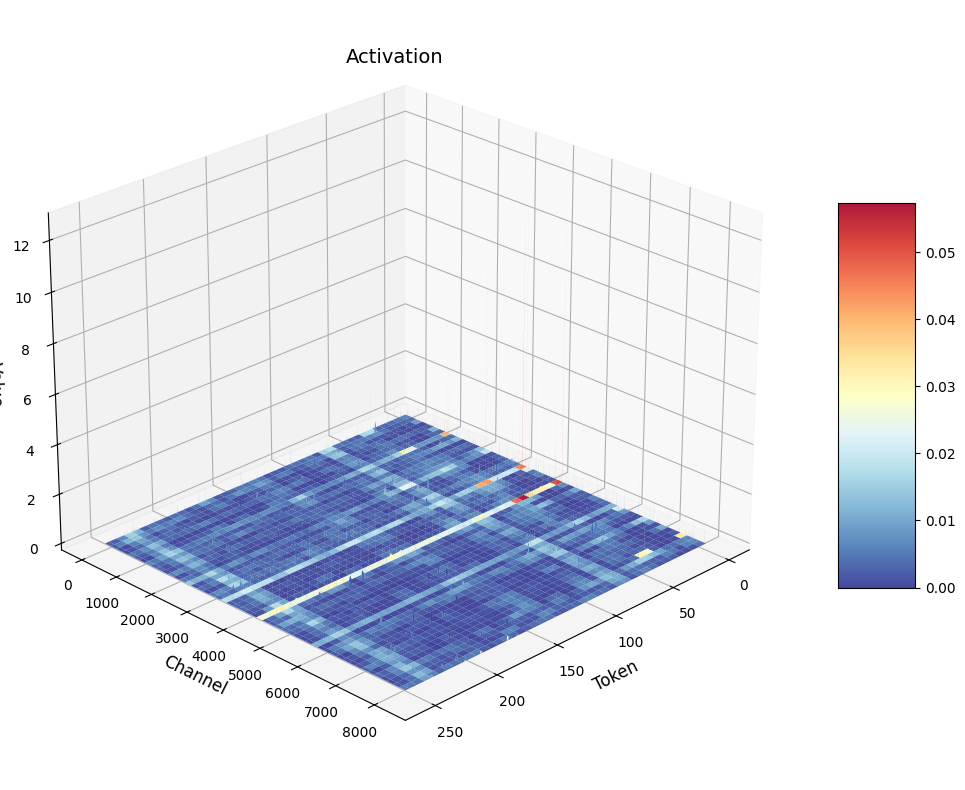

In [23]:
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto") 
@torch.no_grad()
def plot_activation(model , tokenizer , layer_name , n_samples=10 , seq_len=256):
    import matplotlib.pyplot as plt 
    activations = []
    def hook_fn(module, input, output):
        print('Hooked layer output shape' , output.shape)
        activations.append(output.detach().cpu())
    for n, m in model.named_modules():
        if n == layer_name:
            hook=m.register_forward_hook(hook_fn)
            break
    if hook is None:
        raise ValueError(f'Layer {layer_name} not found in the model')
    
    calib_samples = calib_data(tokenizer , n_samples=n_samples , seq_len=seq_len)
    print(f'{len(calib_samples)} calibration samples collected')
    for sample in calib_samples:
        sample = sample.to(model.device)
        print(sample.shape)
        output=model(sample)
        del output
        del sample
    hook.remove()
    print('activation of shape' , len(activations))
    activations_cat = torch.cat(activations , dim=0)
    print('Concatenated activation shape' , activations_cat.shape)
    activations_cat=activations_cat.view(-1,activations_cat.shape[-1])
    plot_3d_activations(activations_cat)
    
    
    

plot_activation(model , tokenizer , layer_name='model.decoder.layers.0.activation_fn')
    
        

AS is seen for an example layer , two channel are consistently (across tokens) outliers compared to other channels .

The idea is AWQ is that the weights that correspond to these activation channels(the ones that are to be multiplied with them) should recieve less noise when quantized . Ideally preserved in full precision

Here we try to gather statistics of each activation in order to decide for each layer weights , what channels to preserve.

In [15]:
@torch.no_grad()
def gather_statistics(model , tokenizer , n_samples=256 , seq_len=512):
    stats={}
    def hook_fn(module, input, output,layer_name):
        
        input=input[0] if isinstance(input, tuple) else input
        input=input.view(-1, input.shape[-1]).abs().mean(dim=0).cpu().detach().numpy()
        if layer_name not in stats:
            stats[layer_name]=[input]
        else:
            stats[layer_name]+=[input]
    hooks=[]
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m._layer_name=n
            hook=m.register_forward_hook(partial(hook_fn,layer_name=n))
            hooks.append(hook)
    calib_samples = calib_data(tokenizer , n_samples=n_samples , seq_len=seq_len)
    for sample in tqdm.tqdm(calib_samples):
        sample = sample.to(model.device)
        output=model(sample)
        del output
        del sample
    for hook in hooks:
        hook.remove()
    # Aggregate stats
    for layer_name in stats:
        stats[layer_name]=np.sum(stats[layer_name],axis=0)
    return stats

In [55]:
def pseudo_quantize_keep_fp16(model, num_bits=4, group_size=-1 ,stats=None):
    
    for n,m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance=stats[n]
            outlier_indices=np.argsort(importance)[-int(0.01*len(importance)):]  # Top 1% as outliers
            assert len(outlier_indices)>0 , "No outliers found , try increasing the percentage of outliers"
            originial_weight = m.weight.data[:, outlier_indices].clone()
            # Quantize all weights 
            m.weight.data=pseudo_quantize_tensor(m.weight.data,num_bits=num_bits,group_size=group_size)
            # Restore outliers to fp16
            m.weight.data[:, outlier_indices]=originial_weight
            
            


In [64]:
stats=gather_statistics(model , tokenizer , n_samples=256 , seq_len=512)

/tmp/ipython-input-639913833.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample=torch.tensor(tokenized)


Collected 256 samples for calibration in  256 iterations


100%|██████████| 33/33 [00:11<00:00,  2.87it/s]


In [56]:
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

pseudo_quantize_keep_fp16(model, num_bits=3, group_size=128 ,stats=stats)
print(f'Quantized model with outlier preservation perplexity: {evaluate_perplexity(model,tokenizer)}')
print(f'Quantized model with outlier preservation size (in MB): {model_size(model,data_width=4,group_size=128)}')

100%|██████████| 50/50 [01:09<00:00,  1.39s/it]

Quantized model with outlier preservation perplexity: 15.257591247558594
Quantized model with outlier preservation size (in MB): 651.9102478027344


Let us do the same thing but randomly this type ( we do not preserve the top 1%)

In [59]:
def pseudo_quantize_keep_fp16_random(model, num_bits=4, group_size=-1 ,stats=None):
    for n,m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance=stats[n]
            outlier_indices=np.random.choice(len(importance), size=int(0.01*len(importance)), replace=False)  # Random 1% as outliers
            originial_weight=m.weight.data[:, outlier_indices].clone()
            # Quantize all weights 
            m.weight.data=pseudo_quantize_tensor(m.weight.data,num_bits=num_bits,group_size=group_size)
            # Restore outliers to fp16
            m.weight.data[:, outlier_indices]=originial_weight

In [60]:
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_keep_fp16_random(model, num_bits=3, group_size=128 ,stats=stats)
print(f'Quantized model with outlier preservation perplexity: {evaluate_perplexity(model,tokenizer)}')
print(f'Quantized model with outlier preservation size (in MB): {model_size(model,data_width=4,group_size=128)}')

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]

Quantized model with outlier preservation perplexity: 92.35659790039062
Quantized model with outlier preservation size (in MB): 651.9102478027344


As we can see there is a significant reduction in perplexity when preserving salient channels , which is wanted  and a spike when arbitrarily protecting channels. But in practice , it is not convinient to keep weights in two precisions. So we must quantize the outlier weights but without introducing much of noise 

If we multiply a weight channel by a constant, the average error introduced by quantization is divided by this constant.

---

### More precisely

We use the quantization formula:

$$ q(w) = \text{Round}\left(\frac{w}{S}\right) + z $$

If we consider a zero point $z = 0$, then:

$$ Q(w) = S \cdot \text{Round}\left(\frac{w}{S}\right) $$

We are mainly interested in the product $Q(w) \cdot x$.  
Without introducing any scale factor:

$$ Q(w) \cdot x = S \cdot \text{Round}\left(\frac{w}{S}\right) \cdot x $$

---

### Introducing a scale

If we scale the weight by a constant $s$, then:

$$ Q(ws) = S' \cdot \text{Round}\left(\frac{w}{S'}\right) \cdot \frac{x}{s} $$

where $S'$ is the new quantization scale after applying the scaling factor $s$.

However, within a group of weights, we usually do **not** expect the quantization scale to change when multiplying specific elements by a constant.  
Thus, we approximate:

$$ Q(ws) = S \cdot \text{Round}\left(\frac{w}{S'}\right) \cdot \frac{x}{s} $$

---

### Quantization Error

The rounding error is empirically about **0.25**. error is  uniformly distributed in $[0,0.5]$

Since the output is divided by $s$, the quantization error becomes smaller.

**Conclusion:** scaling a weight channel reduces quantization error approximately by a factor of $s$.

To see the effect of that , let us simulate the effect of scaling the top 1ù outlier channels and then quantizing it , then bringing it back to normal scale(as if input activation id downscaled)


In [62]:
def pseudo_quantize_scale_fp16(model, num_bits=4, group_size=-1 ,stats=None,scale=2):
    
    for n,m in model.named_modules():
        if isinstance(m, nn.Linear):
            importance=stats[n]
            outlier_indices=np.argsort(importance)[-int(0.01*len(importance)):]  # Top 1% as outliers
            assert len(outlier_indices)>0 , "No outliers found , try increasing the percentage of outliers"
            m.weight.data[:, outlier_indices]*=scale
            # Quantize all weights 
            m.weight.data=pseudo_quantize_tensor(m.weight.data,num_bits=num_bits,group_size=group_size)
            # Restore outliers to fp16
            m.weight.data[:, outlier_indices]/=scale

In [65]:
gc.collect()
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
pseudo_quantize_scale_fp16(model, num_bits=3, group_size=128 ,stats=stats)
print(f'Quantized model with outlier preservation perplexity: {evaluate_perplexity(model,tokenizer)}')
print(f'Quantized model with outlier preservation size (in MB): {model_size(model,data_width=4,group_size=128)}')

100%|██████████| 50/50 [01:12<00:00,  1.44s/it]

Quantized model with outlier preservation perplexity: 17.235485076904297
Quantized model with outlier preservation size (in MB): 651.9102478027344
